# Импорт библиотек

In [1]:
import numpy as np
from gzip import open # NB: overrides standard open()
import pickle as pkl
import pandas as pd
import warnings 
from glob import glob
import os
import math
import functools

### Отключим предупреждения Anaconda

In [2]:
warnings.simplefilter('ignore')

# Загрузим данные

In [3]:
Xdata_numpy = pkl.load(open('C:/Users/admin/Desktop/PLS_continue_2020/X.pkl.gz', 'rb'))
Ydata = pkl.load(open('C:/Users/admin/Desktop/PLS_continue_2020/y.pkl.gz', 'rb'))

# N-PLS1

## Выберем столбец у с которым будем работать

In [4]:
parameters={'numbers_of_learning':10, 'numbers_of_components':55, 'testSize':0.2857, 'column_y':0}

# Приближение к правильному алгоритму

In [5]:
from sklearn.model_selection import train_test_split

#### Центрирование данных

In [6]:
x_centrir=np.array(Xdata_numpy["X"])

In [7]:
y_centrir=Ydata.iloc[:,parameters['column_y']].to_numpy()

In [8]:
for i in range(0,x_centrir.shape[0]):
    a=sum(x_centrir[i,:,:])
    b=sum(a)
    x_centrir[i,:,:]-=(b/(x_centrir.shape[1]*x_centrir.shape[2]))
    a=0
    b=0

In [9]:
b=sum(y_centrir)/y_centrir.shape[0]

In [10]:
y_centrir-=b

#### Делим на тестовый и обучающий наборы

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
        x_centrir, y_centrir, test_size=parameters['testSize'] 
        )

In [12]:
x=X_train
y=y_train
y=np.array(y)
x=np.array(x)

#### Функция ошибок

In [13]:
# a-numpy array;  b-pandas array
def error(a,b):
    s=0
    for i in range(0,len(a)):
        s+=((a[i]-b[i]))**2
    return s

#### Получаем ошибки

In [14]:
Tt=[]
output=np.zeros([parameters['numbers_of_components']])
mass=np.zeros([y.shape[0]])
for f in range(0,parameters['numbers_of_components']):
    z=np.zeros([x.shape[1],x.shape[2]])
    for i in range(0,x.shape[2]):
        for j in range(0,x.shape[1]):
            zsum=0
            for k in range(0,x.shape[0]):
                zsum= zsum+ x[k,j,i]*y[k]
            z[j,i]=zsum
    Wk, S, WI = np.linalg.svd(z)
    w_k=np.array(Wk[0,:]).reshape(x.shape[1],1)
    w_i=np.array(WI[0,:]).reshape(x.shape[2],1)
    t=[]
    for h in range(0,x.shape[0]):
        t+=[np.dot(np.dot(w_k.transpose(),x[h,:,:]),w_i)]
    t=np.array(t).reshape(x.shape[0],1)
    Tt+=[t]
    T=np.array(Tt).reshape(x.shape[0],f+1)
    bf=np.dot(np.dot(np.linalg.inv(np.dot(T.transpose(),T)),T.transpose()),y)
    for g in range(0,x.shape[0]):
        x[g,:,:]=x[g,:,:]-(t[g]*w_i.transpose()*w_k)
    y=y-(np.dot(T,bf))
    mass+=np.dot(T,bf)   
    output[f]+=error(mass,y_train)
np.array(output).reshape(1,parameters['numbers_of_components'])

array([[1.94745134e+03, 1.49079071e+03, 1.41177332e+03, 1.19662222e+03,
        1.04287361e+03, 8.22293027e+02, 6.50435053e+02, 4.16557618e+02,
        3.08903771e+02, 2.60691153e+02, 1.84497072e+02, 1.26782251e+02,
        2.46617822e+01, 1.45987601e+01, 7.93083911e+00, 2.68164607e+00,
        1.31200688e+00, 1.73043424e-01, 4.25630231e-02, 3.91383237e-03,
        9.90047617e-04, 2.54186609e-04, 6.74185911e-05, 4.63432750e-06,
        3.84866346e-21, 2.17804322e-22, 4.29377411e-24, 2.47210339e-21,
        1.12915121e-21, 1.58481347e-19, 5.39737857e-20, 1.05318686e-20,
        1.58730822e-21, 3.20439738e-20, 2.16012040e-18, 2.24801292e-18,
        2.46326154e-18, 9.32601088e-19, 8.17606848e-17, 3.34627895e-16,
        1.08226170e-14, 2.35986460e-12, 7.46269736e-11, 1.82208061e-10,
        1.07342972e-08, 1.24027224e-07, 2.14693087e-07, 5.03615089e-05,
        4.89451839e-04, 1.91370771e-01, 1.07034862e+00, 1.24495455e+02,
        2.37262581e+06, 5.60026780e+08, 3.11516191e+09]])

In [15]:
output

array([1.94745134e+03, 1.49079071e+03, 1.41177332e+03, 1.19662222e+03,
       1.04287361e+03, 8.22293027e+02, 6.50435053e+02, 4.16557618e+02,
       3.08903771e+02, 2.60691153e+02, 1.84497072e+02, 1.26782251e+02,
       2.46617822e+01, 1.45987601e+01, 7.93083911e+00, 2.68164607e+00,
       1.31200688e+00, 1.73043424e-01, 4.25630231e-02, 3.91383237e-03,
       9.90047617e-04, 2.54186609e-04, 6.74185911e-05, 4.63432750e-06,
       3.84866346e-21, 2.17804322e-22, 4.29377411e-24, 2.47210339e-21,
       1.12915121e-21, 1.58481347e-19, 5.39737857e-20, 1.05318686e-20,
       1.58730822e-21, 3.20439738e-20, 2.16012040e-18, 2.24801292e-18,
       2.46326154e-18, 9.32601088e-19, 8.17606848e-17, 3.34627895e-16,
       1.08226170e-14, 2.35986460e-12, 7.46269736e-11, 1.82208061e-10,
       1.07342972e-08, 1.24027224e-07, 2.14693087e-07, 5.03615089e-05,
       4.89451839e-04, 1.91370771e-01, 1.07034862e+00, 1.24495455e+02,
       2.37262581e+06, 5.60026780e+08, 3.11516191e+09])

#### Сразу создам файл для выгрузки результатов этого шага построения модели, что б, когда работа будет идти на финальной стадии не обучаться с нуля

In [16]:
pkl.dump(output,open('C:/Users/admin/Desktop/PLS_continue_2020/output.pkl.gz', 'wb'))

#### Рисуем ошибки

In [18]:
import matplotlib.pyplot as plt

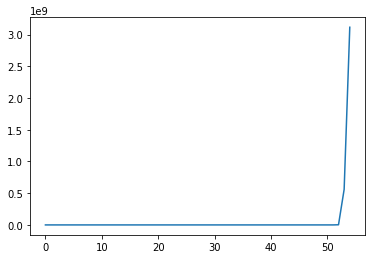

In [19]:
plt.plot(output)
plt.show();

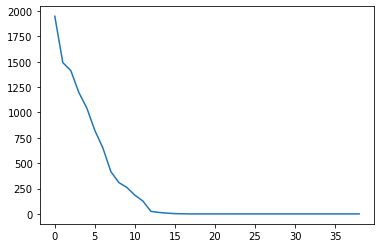

In [20]:
plt.plot(output[0:39])
plt.show();

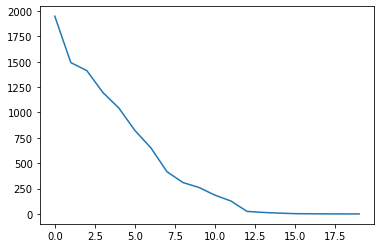

In [21]:
plt.plot(output[0:20])
plt.show();

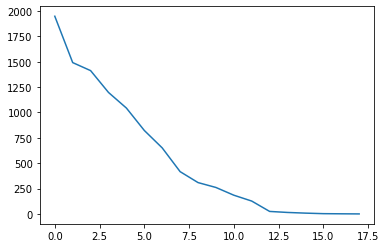

In [22]:
plt.plot(output[0:18])
plt.show();

# Попробую оформить всё в виде полноценного класса

In [ ]:
# пока в планах
class N_PLS1():
    def error(a,b):
        s=0
        for i in range(0,len(a)):
            s+=((a[i]-b.iloc[i]))**2
        return s
    def function_1(x,y,fn):
        Tt=[]
        mass=np.zeros([y.shape[0]])
        output=[]
        for f in range(0,fn):
            z=np.zeros([x.shape[1],x.shape[2]])
            for i in range(0,x.shape[2]):
                for j in range(0,x.shape[1]):
                    zsum=0
                    for k in range(0,x.shape[0]):
                        zsum= zsum+ x[k,j,i]*y[k]
                    z[j,i]=zsum
            Wk, S, WI = np.linalg.svd(z)
            w_k=np.array(Wk[0,:]).reshape(x.shape[1],1)
            w_i=np.array(WI[0,:]).reshape(x.shape[2],1)
            t=[]
            for h in range(0,x.shape[0]):
                t+=[np.dot(np.dot(w_k.transpose(),x[h,:,:]),w_i)]
            t=np.array(t).reshape(x.shape[0],1)
            Tt+=[t]
            T=np.array(Tt).reshape(x.shape[0],f+1)
            bf=np.dot(np.dot(np.linalg.inv(np.dot(T.transpose(),T)),T.transpose()),y)
            for g in range(0,x.shape[0]):
                x[g,:,:]=x[g,:,:]-(t[g]*w_i.transpose()*w_k)
            y=y-(np.dot(T,bf))
            mass+=np.dot(T,bf)
            output+=[error(mass,y_train)]
        return output
    def fit(x,y,fn):
        
            
        return y

In [179]:
y

array([34.19308759, 35.72443085, 46.32211944, 35.69579348, 47.44184036,
       33.34204937, 42.44462856, 39.9018207 , 44.39973652, 54.64066407,
       53.71596802, 44.04933373, 36.11255278, 34.24246421, 36.22622795,
       26.1974747 , 41.0398005 , 31.41066637, 34.07047331, 42.14770231,
       45.44679116, 21.41118209, 44.54683093, 35.35460545, 36.47993911])

In [ ]:
vhmggh

In [395]:
output=np.zeros([parameters['numbers_of_components']])
for v in range(0,parameters['numbers_of_learning']):
    X_train, X_test, y_train, y_test = train_test_split(
        Xdata_numpy["X"], Ydata.iloc[:,parameters['column_y']], test_size=parameters['testSize'] 
        )
    x=X_train
    y=y_train
    y=np.array(y)
    x=np.array(x)
    Tt=[]
    mass=np.zeros([y.shape[0]])
    for f in range(0,parameters['numbers_of_components']):
        z=np.zeros([x.shape[1],x.shape[2]])
        for i in range(0,x.shape[2]):
            for j in range(0,x.shape[1]):
                zsum=0
                for k in range(0,x.shape[0]):
                    zsum= zsum+ x[k,j,i]*y[k]
                z[j,i]=zsum
        Wk, S, WI = np.linalg.svd(z)
        w_k=np.array(Wk[0,:]).reshape(x.shape[1],1)
        w_i=np.array(WI[0,:]).reshape(x.shape[2],1)
        t=[]
        for h in range(0,x.shape[0]):
            t+=[np.dot(np.dot(w_k.transpose(),x[h,:,:]),w_i)]
        t=np.array(t).reshape(x.shape[0],1)
        Tt+=[t]
        T=np.array(Tt).reshape(x.shape[0],f+1)
        bf=np.dot(np.dot(np.linalg.inv(np.dot(T.transpose(),T)),T.transpose()),y)
        for g in range(0,x.shape[0]):
            x[g,:,:]=x[g,:,:]-(t[g]*w_i.transpose()*w_k)
        y=y-(np.dot(T,bf))
        mass+=np.dot(T,bf)   
        output[f]+=error(mass,y_train)
np.array(output).reshape(1,parameters['numbers_of_components'])

array([[5.20396143e+04, 4.91918971e+04, 4.38839916e+04, 3.88590076e+04,
        3.28461510e+04, 2.71640444e+04, 2.06742360e+04, 1.51864921e+04,
        1.08940127e+04, 7.45914196e+03, 5.10460116e+03, 3.13773457e+03,
        1.85325287e+03, 8.68438137e+02, 4.09180232e+02, 2.46334649e+02,
        1.76439608e+02, 1.32129844e+02, 1.09666897e+02, 8.20938712e+01,
        4.59856659e+01, 2.60763430e+01, 1.10681096e+01, 4.58247849e+00,
        9.94812128e-01, 1.09443246e-07, 1.55442375e-08, 1.07111515e-08,
        4.36357780e-09, 8.25991184e-09, 8.28521838e-09, 3.91514087e-08,
        4.05800265e-07, 9.57270667e-08, 3.17840084e-06, 2.82484373e-06,
        6.49010797e-07, 2.30233617e-04, 7.71299123e-03, 1.62744298e-01,
        6.11296107e+01, 1.03835530e+03, 1.01042473e+03, 4.74122861e+03,
        6.23619775e+04, 9.49571644e+04, 1.22425553e+06, 5.50510253e+06,
        5.15620269e+06, 4.28673709e+06, 1.03028491e+09, 1.22720823e+12,
        9.71049882e+14, 6.76286674e+15, 4.44894505e+18]])